<a href="https://colab.research.google.com/github/JamesKevinStar/AnalisisSentimientos/blob/main/Perceptr%C3%B3n%20Multi%20Capa/Proyecto_NLP_Modelo_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio: Clasificación de Tweets de Covid 19 (Análisis de Sentimientos)

#### <a name="Escritura">Alumnos: </a>
*   Estrella Vilca, James Kevin  -  182909
*   Peña Luque, Raísa Melina     -  182927

#### <a name="Escritura">Asignatura: </a>
*   Procesamiento de Lenguaje Natural

#### <a name="Escritura">Docente: </a>
*   Zuñiga Rojas, Gabriela

#### <a name="Escritura">Universidad: </a>
*   Universidad Nacional de San Antonio Abad del Cusco

## Instalar Librerías Necesarias

In [1]:
!python -m spacy download en_core_web_sm
!pip install scikit-learn
!pip install joblib

2023-02-24 23:25:26.564159: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 23:25:28.471087: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-24 23:25:28.471190: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-24 23:25:28.471207: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

## Importar Librerías

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import joblib
import pickle
import spacy
import math
import nltk
import os
import re

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.python.client import device_lib
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras import metrics
from google.colab import drive
from tqdm import tqdm

## Cargar Datos

#### <a name="Escritura">Obtener los datos del Drive</a>

In [3]:
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Procesamiento de Lenguaje Natural/Datos'
print(os.listdir())

Mounted at /content/drive
/content/drive/My Drive/Procesamiento de Lenguaje Natural/Datos
['Coronavirus_Total.xlsx', 'Corona_NLP_train.csv', 'Corona_NLP_test.csv']


#### <a name="Escritura">Mostrar los datos</a>

In [4]:
data = pd.read_excel('Coronavirus_Total.xlsx')
data.head()

,Source.Name,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,Corona_NLP_test.csv,1,44953,NYC,2020-02-03,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,Corona_NLP_test.csv,2,44954,"Seattle, WA",2020-02-03,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Corona_NLP_test.csv,3,44955,NaN,2020-02-03,Find out how you can protect yourself and love...,Extremely Positive
3,Corona_NLP_test.csv,4,44956,Chicagoland,2020-02-03,#Panic buying hits #NewYork City as anxious sh...,Negative
4,Corona_NLP_test.csv,5,44957,"Melbourne, Victoria",2020-03-03,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


#### <a name="Escritura">Eliminar las columnas innecesarias</a>

In [5]:
data.pop('Source.Name')
data.pop('UserName')
data.pop('ScreenName')
data.pop('Location')
data.pop('TweetAt')
data.head()

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


#### <a name="Escritura">Dividir los datos para test y train</a>

In [6]:
x = data.drop(["Sentiment"],axis=1).values
y = data["Sentiment"].values

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.07, random_state=20000901)

## Normalización

#### <a name="Escritura">Reemplazar los saltos de líneas y demás</a>

In [7]:
for tweet in X_train:
  tweet[0]=tweet[0].replace('\n',' ')
  tweet[0]=tweet[0].replace('\r',' ')
  tweet[0]=tweet[0].replace('\t',' ')

for tweet in X_test:
  tweet[0]=tweet[0].replace('\n',' ')
  tweet[0]=tweet[0].replace('\r',' ')
  tweet[0]=tweet[0].replace('\t',' ')

#### <a name="Escritura">Normalizar los datos de test y train</a>

In [8]:
nlp = spacy.load('en_core_web_sm')

X_train_N = [doc[0] for doc in X_train]
Y_train_N = [doc for doc in Y_train]

X_test_N = [doc[0] for doc in X_test]
Y_test_N = [doc for doc in Y_test]

def normalize(sentenses):
    """normalizamos la lista de frases y devolvemos la misma lista de frases normalizada"""
    for index, sentense in enumerate(tqdm(sentenses)):
        sentense = nlp(sentense.lower())
        New_Words = []
        for word in sentense:
            if (not word.is_punct) and (not word.is_stop or (word.text == 'no' or word.text == 'not')) and (not word.text.startswith('@')) and (not word.text.startswith('http')) and (not word.text.startswith('#')) and (not word.text.endswith('.com')) and (not word.text.endswith('.co')) and (not word.text.endswith('.uk')) and (any(map(str.isdigit, word.text)) == False):
                pattern = re.sub(pattern='[^a-z]',repl=' ',string=word.lemma_)
                for p in pattern.split():
                    if len(p) > 2 or p == 'no':
                        New_Words.append(pattern)
        sentenses[index] = ' '.join(New_Words)
    return sentenses

# Normalizamos las frases
X_train_BW = normalize(X_train_N)
X_test_BW = normalize(X_test_N)

100%|██████████| 3147/3147 [00:35<00:00, 89.63it/s] 


#### <a name="Escritura">Dar formato a los datos y eliminar los vacíos tanto en los datos como las etiquetas</a>

In [9]:
def Formato(data,tags):
  X = []
  Y = []
  for i in range(len(data)):
    if data[i] != '':
      lista = []
      for w in data[i].split():
        lista.append(w)
      X.append(lista)
      Y.append(tags[i])
  return X,Y

X_train_Norm,Y_train_Norm = Formato(X_train_BW,Y_train_N)
X_test_Norm,Y_test_Norm = Formato(X_test_BW,Y_test_N)

print(str(len(X_train_Norm))+':',X_train_Norm[0:5])
print(str(len(Y_train_Norm))+':',Y_train_Norm[0:5])
print(str(len(X_test_Norm))+':',X_test_Norm[0:5])
print(str(len(Y_test_Norm))+':',Y_test_Norm[0:5])

41761: [['oio', 'casino', 'egcc', 'btc', 'soon', 'news', 'pandemic', 'spread', 'world', 'stock', 'forex', 'cryptocurrencie', 'see', 'huge', 'fall', 'price', 'bitc', 'read'], ['podcast', 'coronavirus', 'outbreak', 'protest', 'retail', 'store', 'closure'], ['online', 'shopping', 'benefit', 'short', 'term', 'supply', 'chain', 'issue', 'uncertain', 'consumer', 'demand', 'dampen', 'commerce', 'outlook', 'coronavirus', 'affect', 'ecommerce', 'world'], ['hilarious', 'scary', 'tragic', 'could', 'buy', 'little', 'please', 'panic', 'buy', 'disrupt', 'food', 'distribution', 'coronavirus', 'outbreak', 'guardian', 'pandemic'], ['hand', 'sanitize', 'safe', 'let', 'minimise', 'chance', 'contract', 'deadly', 'large', 'portable', 'hand', 'sanitizer', 'amp', 'face', 'mask', 'available', 'order', 'deliver', 'doorstep', 'kampala']]
41761: ['Positive', 'Negative', 'Positive', 'Extremely Negative', 'Extremely Positive']
3146: [['lady', 'need', 'eye', 'talk', 'yes', 'dad', 'bod', 'supply', 'eat', 'week', 'ey

#### <a name="Escritura">Normalizar las etiquetas de test y train</a>

In [10]:
encoder = LabelEncoder()
encoder.fit(Y_train_Norm)
Y_matrix_train = encoder.transform(Y_train_Norm)
Y_matrix_test = encoder.transform(Y_test_Norm)
print(Y_matrix_train[0:21])
print(Y_matrix_test[0:21])

[4 2 4 0 1 3 1 4 3 1 4 3 3 3 4 1 1 0 3 4 2]
[4 3 3 1 4 0 2 4 2 3 0 4 1 3 2 4 4 3 0 4 2]


#### <a name="Escritura">Guardar los datos normalizados</a>

In [ ]:
Ruta = '/content/drive/My Drive/Procesamiento de Lenguaje Natural/Datos Normalizados/'
Filename = [Ruta + 'X_Normalizado_Train.pickle',Ruta + 'Y_Normalizado_Train.pickle',Ruta + 'X_Normalizado_Test.pickle',Ruta + 'Y_Normalizado_Test.pickle']
Data = [X_train_Norm,Y_matrix_train,X_test_Norm,Y_matrix_test]
for i in range(len(Filename)):
  Save_List = open(Filename[i],'wb')
  pickle.dump(Data[i],Save_List)
  Save_List.close()

#### <a name="Escritura">Cargar los datos normalizados</a>

In [ ]:
Ruta = '/content/drive/My Drive/Procesamiento de Lenguaje Natural/Datos Normalizados/'
Filename = [Ruta + 'X_Normalizado_Train.pickle',Ruta + 'Y_Normalizado_Train.pickle',Ruta + 'X_Normalizado_Test.pickle',Ruta + 'Y_Normalizado_Test.pickle']

X_train_Norm = pickle.load(open(Filename[0], 'rb'))
Y_matrix_train = pickle.load(open(Filename[1], 'rb'))
X_test_Norm = pickle.load(open(Filename[2], 'rb'))
Y_matrix_test = pickle.load(open(Filename[3], 'rb'))

## Bolsa de Palabras

#### <a name="Escritura">Obtener la matriz para el entrenamiento</a>

In [11]:
num_words = 4000

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train_Norm)
X_matrix_train = tokenizer.texts_to_matrix(X_train_Norm, mode='count')
X_matrix_test = tokenizer.texts_to_matrix(X_test_Norm, mode='count')

print('Dimensión de la matriz de entrenamiento: {dim}\n'.format(dim=X_matrix_train.shape))
print('Bolsa de palabras de los datos de entrenamiento:\n{bolsa}\n'.format(bolsa=dict(list(tokenizer.word_counts.items())[0:10])))
print('Índice de las palabras en la Matriz:\n{index}\n'.format(index=dict(list(tokenizer.word_index.items())[0:10])))
print('Matriz de entrenamiento:\n{matrix}\n'.format(matrix=X_matrix_train[:,0:5]))
print('Matriz de test:\n{matrix}\n'.format(matrix=X_matrix_test[:,0:5]))

print(len(tokenizer.word_counts))

Dimensión de la matriz de entrenamiento: (41761, 4000)

Bolsa de palabras de los datos de entrenamiento:
{'oio': 2, 'casino': 12, 'egcc': 1, 'btc': 22, 'soon': 292, 'news': 789, 'pandemic': 2957, 'spread': 1260, 'world': 989, 'stock': 3205}

Índice de las palabras en la Matriz:
{'coronavirus': 1, 'store': 2, 'price': 3, 'food': 4, 'supermarket': 5, 'grocery': 6, 'people': 7, 'amp': 8, 'not': 9, 'consumer': 10}

Matriz de entrenamiento:
[[0. 0. 0. 1. 0.]
 [0. 1. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

Matriz de test:
[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0.]]

36149


## Definición de Red Neuronal

#### <a name="Escritura">Definir la arquitectura de la red neuronal</a>

In [ ]:
np.random.seed(0)
model = Sequential()
model.add(Dense(4000, activation='relu', input_dim=num_words))
model.add(Dropout(0.1))
model.add(Dense(3651, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(3275, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2742, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2392, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1874, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1278, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(713, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(395, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(132, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(63, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(18, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(5, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 4000)              16004000  
                                                                 
 dropout_24 (Dropout)        (None, 4000)              0         
                                                                 
 dense_27 (Dense)            (None, 3651)              14607651  
                                                                 
 dropout_25 (Dropout)        (None, 3651)              0         
                                                                 
 dense_28 (Dense)            (None, 3275)              11960300  
                                                                 
 dropout_26 (Dropout)        (None, 3275)              0         
                                                                 
 dense_29 (Dense)            (None, 2742)             

## Entrenamiento de la Red Neuronal

#### <a name="Escritura">Entrenar la red neuronal</a>

In [ ]:
history = model.fit(X_matrix_train, Y_matrix_train, batch_size=15, epochs=5, verbose=2, validation_data=(X_matrix_test, Y_matrix_test))

Epoch 1/5
2785/2785 - 45s - loss: 1.2913 - accuracy: 0.4463 - val_loss: 1.0887 - val_accuracy: 0.5594 - 45s/epoch - 16ms/step
Epoch 2/5
2785/2785 - 44s - loss: 0.9863 - accuracy: 0.6217 - val_loss: 1.0031 - val_accuracy: 0.6567 - 44s/epoch - 16ms/step
Epoch 3/5
2785/2785 - 44s - loss: 0.7997 - accuracy: 0.7222 - val_loss: 1.1514 - val_accuracy: 0.6570 - 44s/epoch - 16ms/step
Epoch 4/5
2785/2785 - 44s - loss: 0.6191 - accuracy: 0.8015 - val_loss: 1.2567 - val_accuracy: 0.6538 - 44s/epoch - 16ms/step
Epoch 5/5
2785/2785 - 44s - loss: 0.4811 - accuracy: 0.8583 - val_loss: 2.7011 - val_accuracy: 0.6669 - 44s/epoch - 16ms/step


#### <a name="Escritura">Graficar la función de perdida</a>

In [ ]:
%matplotlib inline
# Pintamos las métricas por epoch
def plot_metric(history, name, remove_first=0):
    metric_train = np.array(history.history[name])[remove_first:]
    metric_test = np.array(history.history['val_{}'.format(name)])[remove_first:]
    acum_avg_metric_train = (np.cumsum(metric_train) / (np.arange(metric_train.shape[-1]) + 1))[remove_first:]
    acum_avg_metric_test = (np.cumsum(metric_test) / (np.arange(metric_test.shape[-1]) + 1))[remove_first:]
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title('{} - Epochs'.format(name))
    plt.plot(metric_train, label='{} Train'.format(name))
    plt.plot(metric_test, label='{} Test'.format(name))
    plt.grid()
    plt.legend(loc='upper center')
    plt.subplot(1, 2, 2)
    plt.title('AVG ACCUMULATIVE {} - Epochs'.format(name))
    plt.plot(acum_avg_metric_train, label='{} Train'.format(name))
    plt.plot(acum_avg_metric_test, label='{} Test'.format(name))
    plt.grid()
    plt.legend(loc='upper center')
    plt.show()

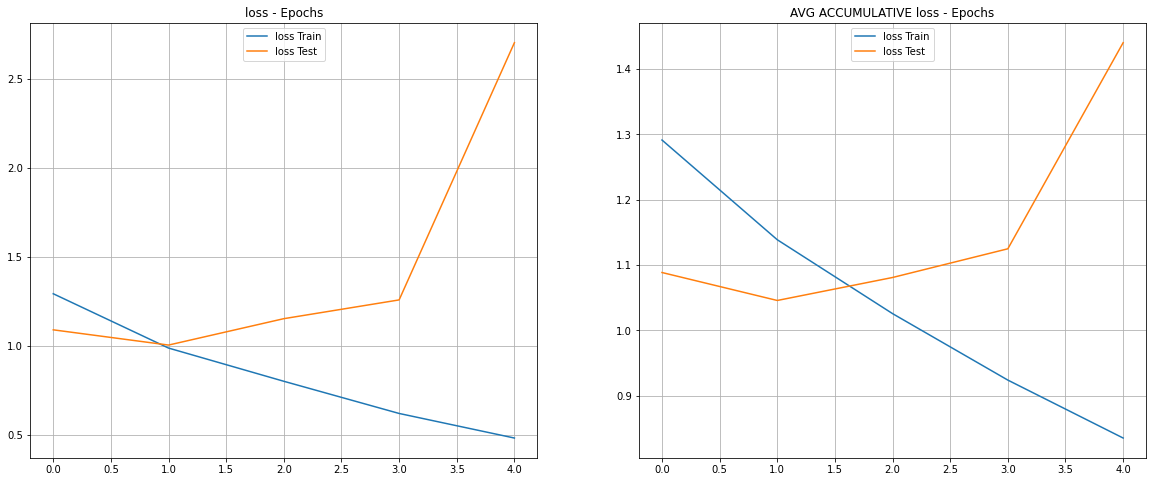

In [ ]:
plot_metric(history=history, name='loss')

#### <a name="Escritura">Graficar la función de accuracy</a>

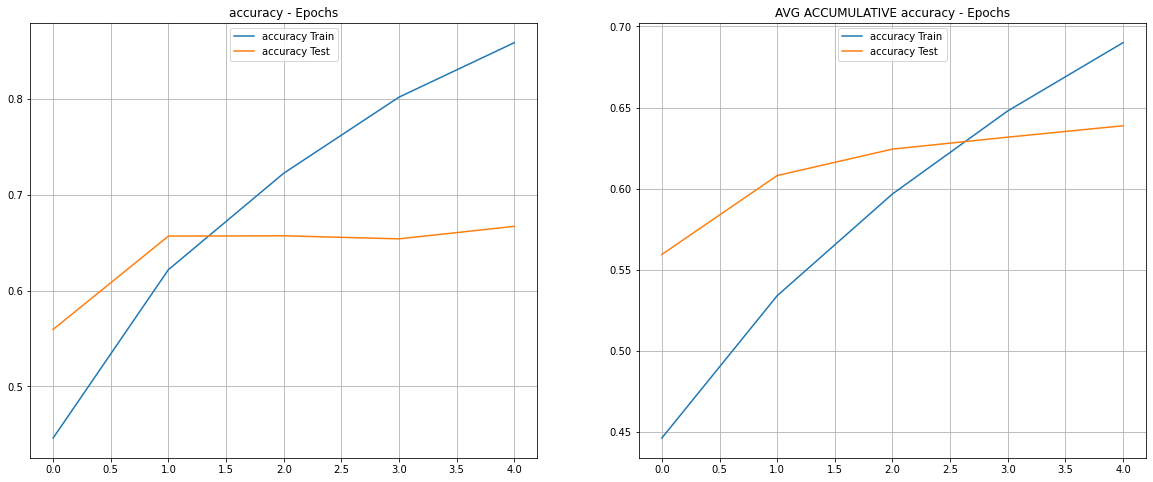

In [ ]:
plot_metric(history=history, name='accuracy')

## Guardar Modelo Entrenado

In [ ]:
joblib.dump(history,'/content/drive/My Drive/Procesamiento de Lenguaje Natural/Redes Neuronales Entrenadas/Modelo_Entrenado_Red_Neuronal.pkl')

['/content/drive/My Drive/Procesamiento de Lenguaje Natural/Redes Neuronales Entrenadas/Modelo_Entrenado_Red_Neuronal.pkl']

## Evaluación del Modelo

#### <a name="Escritura">Calcular las diferentes métricas</a>

In [ ]:
Y_true = encoder.inverse_transform(Y_matrix_test.reshape(-1))
X_pred = model.predict(X_matrix_test)
X_pred_train = model.predict(X_matrix_train)
Y_pred = np.argmax(X_pred,axis=1)
Y_pred_train = np.argmax(X_pred_train,axis=1)
Y_pred = encoder.inverse_transform(Y_pred.reshape(-1))

print('Accuracy: {acc:0.4f}'.format(acc=accuracy_score(y_true=Y_true, y_pred=Y_pred)))
print('F1: {f1:0.4f}'.format(f1=f1_score(y_true=Y_true, y_pred=Y_pred, average='weighted')))
print('Precision: {pre:0.4f}'.format(pre=precision_score(y_true=Y_true, y_pred=Y_pred, average='weighted')))
print('Recall: {rec:0.4f}'.format(rec=recall_score(y_true=Y_true, y_pred=Y_pred, average='weighted')))
print(classification_report(y_true=Y_true, y_pred=Y_pred))
Labels = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']
confusion_matrix_test = confusion_matrix(y_true=Y_true,
                                         y_pred=Y_pred,
                                         labels=Labels)
confusion_matrix_train = confusion_matrix(y_true=encoder.inverse_transform(Y_matrix_train.reshape(-1)), 
                                          y_pred=encoder.inverse_transform(Y_pred_train), 
                                          labels=Labels)

Accuracy: 0.6669
F1: 0.6683
Precision: 0.6733
Recall: 0.6669
                    precision    recall  f1-score   support

Extremely Negative       0.72      0.66      0.69       384
Extremely Positive       0.76      0.65      0.70       490
          Negative       0.60      0.66      0.63       775
           Neutral       0.74      0.68      0.71       615
          Positive       0.63      0.68      0.65       882

          accuracy                           0.67      3146
         macro avg       0.69      0.67      0.67      3146
      weighted avg       0.67      0.67      0.67      3146



#### <a name="Escritura">Mostrar las matrices de confusión</a>

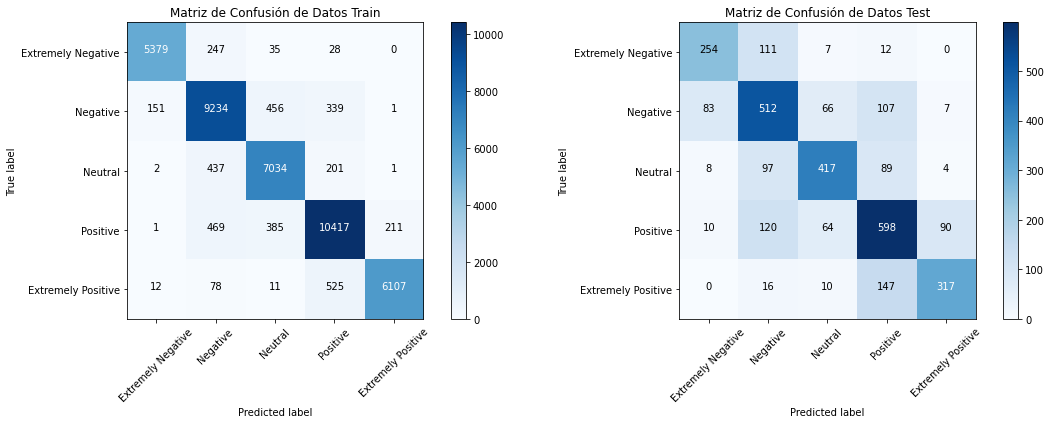

In [ ]:
%matplotlib inline

def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_confusion_matrix(confusion_matrix_train, classes=Labels, title='Matriz de Confusión de Datos Train')
plt.subplot(1, 2, 2)
plot_confusion_matrix(confusion_matrix_test, classes=Labels, title='Matriz de Confusión de Datos Test')
plt.show()